## **Autoencoder**




Vanilla Autoencoder


In [1]:
import torch

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
# Код загрузки
import numpy as np
import os
from imageio import imread
from PIL import Image

import pandas as pd

#np.array(Image.fromarray(img).resize([dimx,dimy]))

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)
    
    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx,dimy])) )

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs
    

In [3]:
 # Загружаем изображения и их атрибуты
data, attrs = fetch_dataset()
IMAGE_H = data.shape[1]
IMAGE_W = data.shape[2]
N_CHANNELS = 3

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)

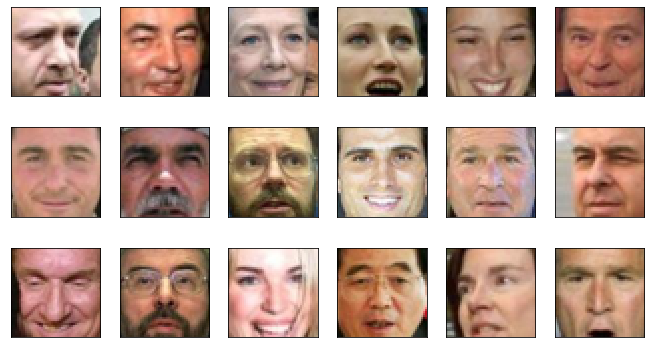

In [24]:
def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)) , cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())
        except:
            pass


plot_gallery(X_train / 255, IMAGE_H, IMAGE_W)

In [25]:
inp_size=X_train.shape[1]
hid_size=250
dim_z = 100
DEVICE = torch.device("cuda")

In [26]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(45*45*3,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000, dim_z),
            nn.BatchNorm1d(dim_z),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_z,1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Linear(1000,1500),
            nn.BatchNorm1d(1500),
            nn.ReLU(),
            nn.Linear(1500,45*45*3)
        )
      
    def encode(self,x):
        return self.encoder(x)
    
    def decode(self,z):
        return self.decoder(z)
        
    def forward(self, x):
        encoded = self.encode(x)  
        decoded = self.decode(encoded)  
        return encoded, decoded

In [27]:
model_auto = Autoencoder().to(DEVICE)

In [28]:
def get_batch(data, batch_size=32):
    total_len = data.shape[0]
    for i in range(0, total_len, batch_size):
        yield data[i:min(i+batch_size,total_len)]

def plot_gallery(images, h, w, n_row=3, n_col=6, with_title=False, titles=[]):
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        try:
            plt.imshow(images[i].reshape((h, w, 3)) / 255, cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
            if with_title:
                plt.title(titles[i])
            plt.xticks(())
            plt.yticks(())
        except:
            pass
        
def fit_epoch(model, train_x, criterion, optimizer, batch_size, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    
    for inputs in get_batch(train_x,batch_size):
        
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        optimizer.zero_grad()
        
        encoder, decoder = model(inputs)
        
        if not is_cnn:
            outputs = decoder.view(-1, 45*45*3)
        else:
            outputs = decoder.permute(0,2,3,1)
        
        loss = criterion(outputs,inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.shape[0]
        processed_data += inputs.shape[0]
    
    train_loss = running_loss / processed_data    
    return train_loss

def eval_epoch(model, x_val, criterion, is_cnn=False):
    running_loss = 0.0
    processed_data = 0
    model.eval()
    
    for inputs in get_batch(x_val):
        if not is_cnn:
            inputs = inputs.view(-1, 45*45*3)
        inputs = inputs.to(DEVICE)
        
        with torch.set_grad_enabled(False):
            encoder, decoder = model(inputs)
            
            if not is_cnn:
                outputs = decoder.view(-1, 45*45*3)
            else:
                outputs = decoder.permute(0,2,3,1)
                
            loss = criterion(outputs,inputs)
            running_loss += loss.item() * inputs.shape[0]
            processed_data += inputs.shape[0]
    
    val_loss = running_loss / processed_data
    
    #draw
    with torch.set_grad_enabled(False):
        pic = x_val[3]
        
        if not is_cnn:            
            pic_input = pic.view(-1, 45*45*3)
        else:
            pic_input = torch.FloatTensor(pic.unsqueeze(0))
            
            
        pic_input = pic_input.to(DEVICE)
        
        encoder, decoder = model(pic_input)
        
        if not is_cnn:
            pic_output = decoder.view(-1, 45*45*3).squeeze()
        else:
            
            pic_output = decoder.permute(0,2,3,1)
            
        pic_output = pic_output.to("cpu")
        
        
        pic_input = pic_input.to("cpu")
        
        plot_gallery([pic_input, pic_output],45,45,1,2)
    
    return val_loss

def train(train_x, val_x, model, epochs=10, batch_size=32, is_cnn=False):     
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)        
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss: {val_loss:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):            
            train_loss = fit_epoch(model,train_x,criterion,optimizer,batch_size,is_cnn)
            val_loss = eval_epoch(model,val_x,criterion, is_cnn)
            print("loss: ", train_loss)

            history.append((train_loss,val_loss))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, val_loss=val_loss))            
        
    return history

epoch:   2%|▎         | 1/40 [00:02<01:21,  2.10s/it]

loss:  8396.78365973345

Epoch 001 train_loss: 8396.7837 val_loss: 2885.1157


epoch:   5%|▌         | 2/40 [00:04<01:20,  2.11s/it]

loss:  1467.0113446208627

Epoch 002 train_loss: 1467.0113 val_loss: 1355.1973


epoch:   8%|▊         | 3/40 [00:06<01:18,  2.11s/it]

loss:  1338.8763942301262

Epoch 003 train_loss: 1338.8764 val_loss: 1332.8462


epoch:  10%|█         | 4/40 [00:08<01:16,  2.11s/it]

loss:  1208.7172782133123

Epoch 004 train_loss: 1208.7173 val_loss: 1123.5270


epoch:  12%|█▎        | 5/40 [00:10<01:14,  2.12s/it]

loss:  1091.1946116348217

Epoch 005 train_loss: 1091.1946 val_loss: 1091.1144


epoch:  15%|█▌        | 6/40 [00:12<01:11,  2.12s/it]

loss:  1069.3554930618923

Epoch 006 train_loss: 1069.3555 val_loss: 1055.9157


epoch:  18%|█▊        | 7/40 [00:14<01:09,  2.12s/it]

loss:  985.4441247816342

Epoch 007 train_loss: 985.4441 val_loss: 946.7737


epoch:  20%|██        | 8/40 [00:16<01:07,  2.12s/it]

loss:  888.8381207055957

Epoch 008 train_loss: 888.8381 val_loss: 885.8579


epoch:  22%|██▎       | 9/40 [00:19<01:05,  2.12s/it]

loss:  849.7433667196528

Epoch 009 train_loss: 849.7434 val_loss: 847.5719


epoch:  25%|██▌       | 10/40 [00:21<01:03,  2.13s/it]

loss:  816.4382445778211

Epoch 010 train_loss: 816.4382 val_loss: 840.0440


epoch:  28%|██▊       | 11/40 [00:23<01:01,  2.13s/it]

loss:  778.6577437416963

Epoch 011 train_loss: 778.6577 val_loss: 784.7477


epoch:  30%|███       | 12/40 [00:25<00:59,  2.13s/it]

loss:  768.9785400413846

Epoch 012 train_loss: 768.9785 val_loss: 782.5417


epoch:  32%|███▎      | 13/40 [00:27<00:57,  2.13s/it]

loss:  760.8912877022415

Epoch 013 train_loss: 760.8913 val_loss: 763.6545


epoch:  35%|███▌      | 14/40 [00:29<00:55,  2.14s/it]

loss:  730.4967009667913

Epoch 014 train_loss: 730.4967 val_loss: 729.2208


epoch:  38%|███▊      | 15/40 [00:31<00:53,  2.13s/it]

loss:  713.374366160874

Epoch 015 train_loss: 713.3744 val_loss: 722.4609


epoch:  40%|████      | 16/40 [00:34<00:51,  2.13s/it]

loss:  704.4562280403472

Epoch 016 train_loss: 704.4562 val_loss: 721.5161


epoch:  42%|████▎     | 17/40 [00:36<00:49,  2.14s/it]

loss:  697.2233292041044

Epoch 017 train_loss: 697.2233 val_loss: 696.3417


epoch:  45%|████▌     | 18/40 [00:38<00:46,  2.13s/it]

loss:  669.2865052581491

Epoch 018 train_loss: 669.2865 val_loss: 677.4183


epoch:  48%|████▊     | 19/40 [00:40<00:45,  2.16s/it]

loss:  660.3567190592975

Epoch 019 train_loss: 660.3567 val_loss: 677.4370


epoch:  50%|█████     | 20/40 [00:42<00:43,  2.15s/it]

loss:  655.3371103572283

Epoch 020 train_loss: 655.3371 val_loss: 661.1234


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
epoch:  52%|█████▎    | 21/40 [00:44<00:40,  2.15s/it]

loss:  638.924886539859

Epoch 021 train_loss: 638.9249 val_loss: 646.2534


epoch:  55%|█████▌    | 22/40 [00:46<00:38,  2.14s/it]

loss:  628.1740505776525

Epoch 022 train_loss: 628.1741 val_loss: 646.2116


epoch:  57%|█████▊    | 23/40 [00:49<00:36,  2.13s/it]

loss:  624.128765045973

Epoch 023 train_loss: 624.1288 val_loss: 650.4852


epoch:  60%|██████    | 24/40 [00:51<00:34,  2.13s/it]

loss:  618.1304611545655

Epoch 024 train_loss: 618.1305 val_loss: 627.2756


epoch:  62%|██████▎   | 25/40 [00:53<00:31,  2.13s/it]

loss:  601.2610909249906

Epoch 025 train_loss: 601.2611 val_loss: 605.9658


epoch:  65%|██████▌   | 26/40 [00:55<00:29,  2.13s/it]

loss:  592.3375472050101

Epoch 026 train_loss: 592.3375 val_loss: 601.4320


epoch:  68%|██████▊   | 27/40 [00:57<00:27,  2.13s/it]

loss:  584.4847165391271

Epoch 027 train_loss: 584.4847 val_loss: 597.4013


epoch:  70%|███████   | 28/40 [00:59<00:25,  2.13s/it]

loss:  577.7865175882491

Epoch 028 train_loss: 577.7865 val_loss: 591.2732


epoch:  72%|███████▎  | 29/40 [01:01<00:23,  2.13s/it]

loss:  572.4466595344043

Epoch 029 train_loss: 572.4467 val_loss: 582.0302


epoch:  75%|███████▌  | 30/40 [01:03<00:21,  2.12s/it]

loss:  553.659275361878

Epoch 030 train_loss: 553.6593 val_loss: 558.2978


epoch:  78%|███████▊  | 31/40 [01:06<00:19,  2.12s/it]

loss:  539.0419769606392

Epoch 031 train_loss: 539.0420 val_loss: 551.5494


epoch:  80%|████████  | 32/40 [01:08<00:16,  2.12s/it]

loss:  531.1375089503523

Epoch 032 train_loss: 531.1375 val_loss: 552.7916


epoch:  82%|████████▎ | 33/40 [01:10<00:14,  2.12s/it]

loss:  523.6478395714197

Epoch 033 train_loss: 523.6478 val_loss: 539.1375


epoch:  85%|████████▌ | 34/40 [01:12<00:12,  2.12s/it]

loss:  507.68849510409115

Epoch 034 train_loss: 507.6885 val_loss: 521.7812


epoch:  88%|████████▊ | 35/40 [01:14<00:10,  2.12s/it]

loss:  503.5575853463518

Epoch 035 train_loss: 503.5576 val_loss: 515.9853


epoch:  90%|█████████ | 36/40 [01:16<00:08,  2.12s/it]

loss:  498.1504146988818

Epoch 036 train_loss: 498.1504 val_loss: 513.5700


epoch:  92%|█████████▎| 37/40 [01:18<00:06,  2.12s/it]

loss:  490.54916913586015

Epoch 037 train_loss: 490.5492 val_loss: 510.7150


epoch:  95%|█████████▌| 38/40 [01:20<00:04,  2.13s/it]

loss:  485.6461399275018

Epoch 038 train_loss: 485.6461 val_loss: 509.4304


epoch:  98%|█████████▊| 39/40 [01:23<00:02,  2.13s/it]

loss:  480.9248406677072

Epoch 039 train_loss: 480.9248 val_loss: 502.7016


epoch: 100%|██████████| 40/40 [01:25<00:00,  2.13s/it]

loss:  475.86944075612166

Epoch 040 train_loss: 475.8694 val_loss: 502.9482


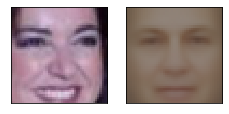

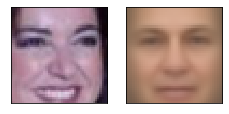

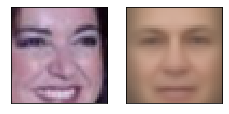

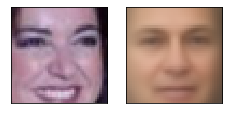

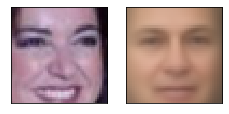

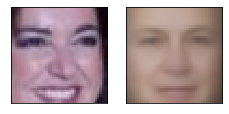

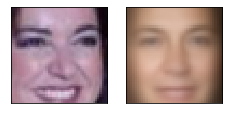

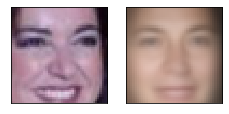

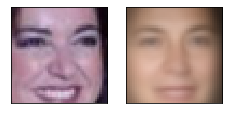

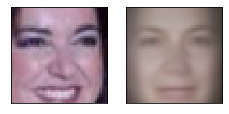

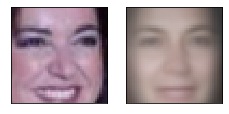

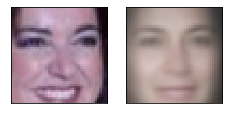

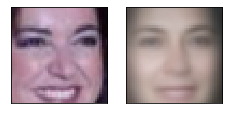

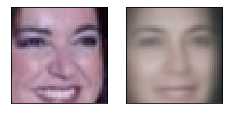

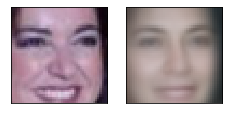

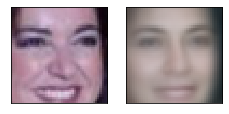

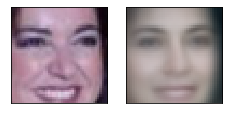

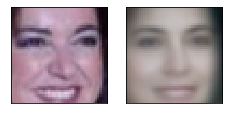

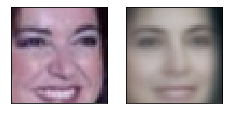

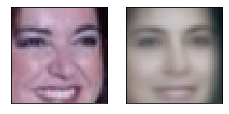

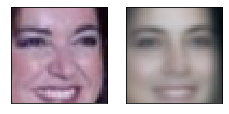

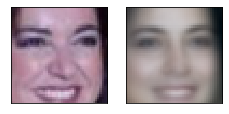

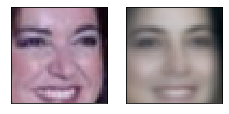

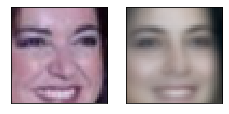

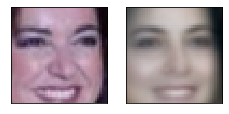

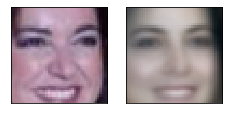

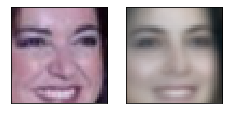

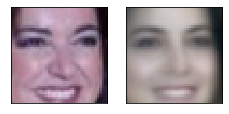

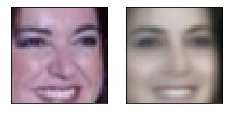

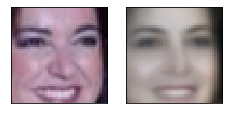

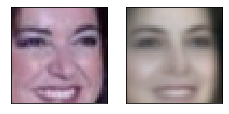

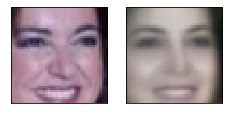

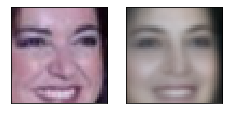

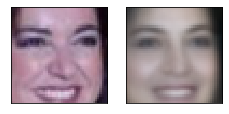

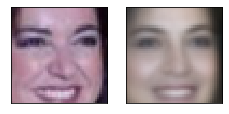

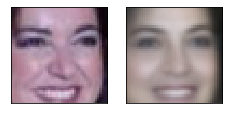

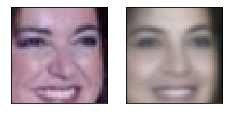

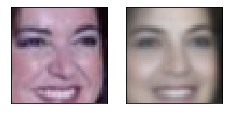

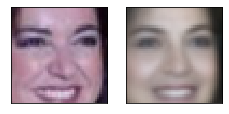

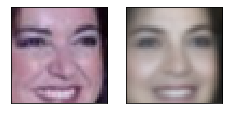

In [29]:
history = train(X_train, X_val, model_auto, epochs=40, batch_size=64)

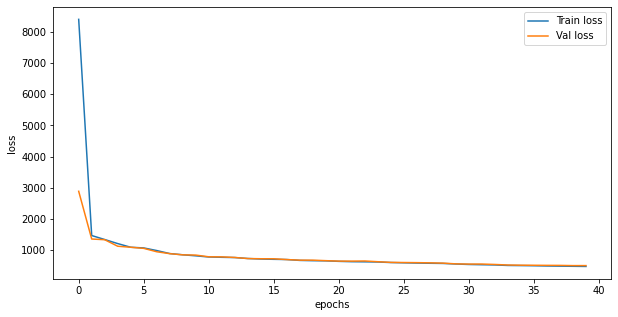

In [30]:
train_loss, val_loss = zip(*history)
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

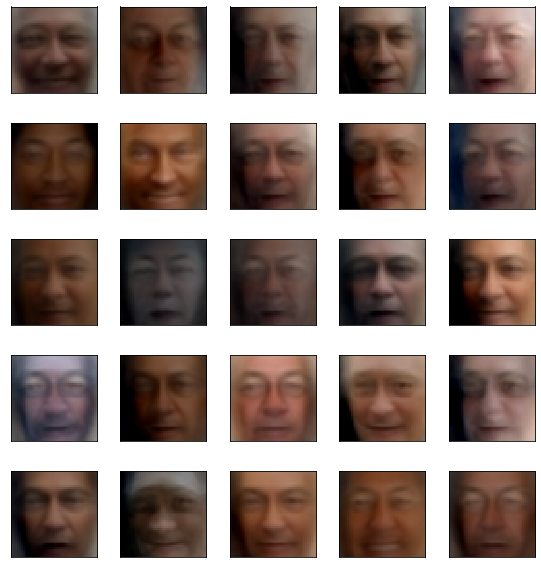

In [31]:
z = np.random.randn(25, dim_z)
print(z.shape)

with torch.no_grad():
    inputs = torch.FloatTensor(z)
    
    inputs = inputs.to(DEVICE)
    model_auto.eval()
    output = model_auto.decode(inputs)
    
    plot_gallery(output.data.cpu().numpy() , IMAGE_H, IMAGE_W, n_row=5, n_col=5)

In [32]:
smile_ids = attrs['Smiling'].sort_values(ascending=False).iloc[100:125].index.values
smile_data = data[smile_ids]
no_smile_ids = attrs['Smiling'].sort_values(ascending=True).head(25).index.values
no_smile_data = data[no_smile_ids]

In [33]:
def to_latent(pic):
    with torch.no_grad():
        inputs = torch.FloatTensor(pic.reshape(-1, 45*45*3))
        inputs = inputs.to(DEVICE)
        model_auto.eval()
        output = model_auto.encoder(inputs)        
        return output

def from_latent(vec):
    with torch.no_grad():
        inputs = vec.to(DEVICE)
        model_auto.eval()
        output = model_auto.decoder(inputs)        
        return output

In [34]:
smile_latent = to_latent(smile_data).mean(axis=0)
no_smile_latent = to_latent(no_smile_data).mean(axis=0)


smile_vec = smile_latent - no_smile_latent


def smile(ids):
    for id in ids:
        pic = data[id:id+1]
        latent_vec = to_latent(pic)
        latent_vec[0] += smile_vec
        pic_output = from_latent(latent_vec)
        pic_output = pic_output.view(-1,45,45,3).cpu()
        plot_gallery([pic,pic_output], IMAGE_H, IMAGE_W, n_row=1, n_col=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


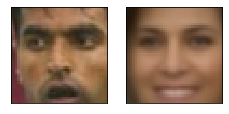

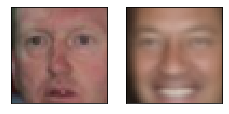

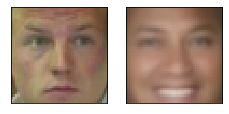

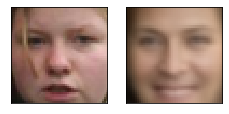

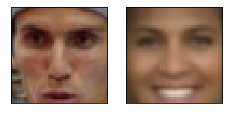

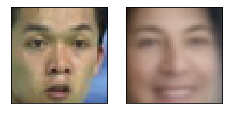

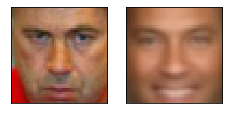

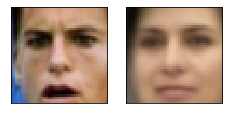

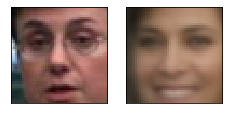

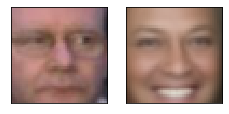

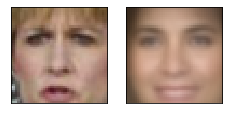

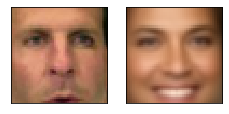

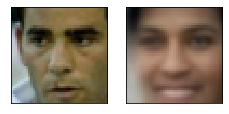

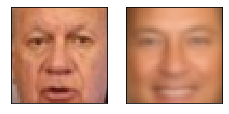

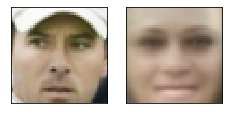

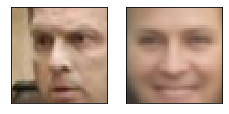

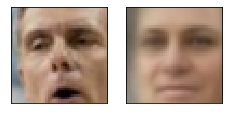

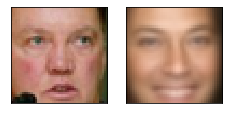

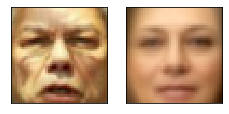

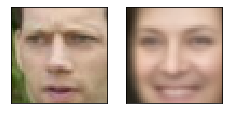

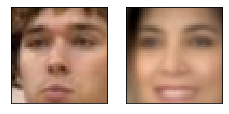

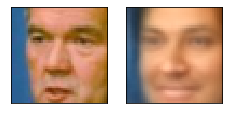

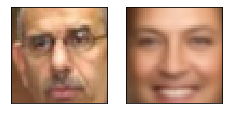

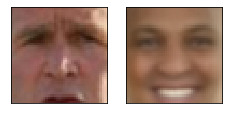

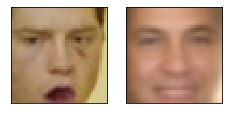

In [35]:
smile(no_smile_ids)